## View this in Binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cstenkamp/derive_conceptualspaces/main?labpath=notebooks%2Ftext_referenced_plots%2Fhyperplane_orthogonal_3d.ipynb)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn import svm, datasets
from dataclasses import dataclass
from sklearn.datasets import make_blobs
import math
import numpy as np

In [ ]:
import plotly.express as pe
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [ ]:
def ortho_projection_affine(a, b):
    """https://en.wikipedia.org/wiki/Vector_projection"""
    return np.dot(np.dot(a,b)/np.dot(b,b),b)

class ThreeDFigure():
    def __init__(self, trafo_fn=None, back_trafo_fn=None, swap_axes=None):
        self.trafo_fn = trafo_fn if trafo_fn is not None else lambda x: x
        self.back_trafo_fn = back_trafo_fn if back_trafo_fn is not None else lambda x: x
        self.swap_axes = swap_axes
        #https://community.plotly.com/t/creating-a-3d-scatterplot-with-equal-scale-along-all-axes/15108/7
        self.fig = go.Figure(layout=go.Layout(
                        scene=dict(camera=dict(eye=dict(x=1, y=1, z=1)), aspectmode="data"),
                        autosize=True,
                        width=1000,
                        height=800,
                        margin=dict(l=10, r=10, b=10, t=10, pad=4),
                        paper_bgcolor="White"))
        self.shown_legendgroups = []
        
    def _transform(self, points, inverse=False):
        trafo_fn = self.back_trafo_fn if inverse else self.trafo_fn              
        points = np.array([trafo_fn(point) for point in points])    
        if self.swap_axes:
            points = self._swap_axes(points, self.swap_axes)
        return points
    
    def _swap_axes(self, points, swap_axes):
        swap_translate = {"x": 0, "y": 1, "z": 2}
        ind1, ind2 = swap_translate[swap_axes[0]], swap_translate[swap_axes[1]]
        tmp = points[:,ind1].copy()
        points[:,ind1] = points[:,ind2]
        points[:,ind2] = tmp
        return points
    
                    
    def add_surface(self, xx, yy, z_func, swap_axes=None, opacity=None, **kwargs):
        xy_arr = np.vstack([xx.flatten(), yy.flatten()]).T
        z_arr = np.array([z_func(*i) for i in xy_arr])
        points = np.column_stack([xy_arr, z_arr])
        points = self._transform(points)
        if swap_axes: 
            points = self._swap_axes(points, swap_axes)
        surface_form = lambda x: x.reshape(round(math.sqrt(x.shape[0])),-1)
        self.fig.add_trace(go.Surface(x=surface_form(points[:,0]), y=surface_form(points[:,1]), z=surface_form(points[:,2]), opacity=opacity, showlegend=True, showscale=False, **kwargs))
    
    
    def add_line(self, point1, point2, width=6, do_transform=True, name=None, legendgroup=None, color=None, **kwargs):
        if do_transform:
            point1 = self._transform(np.array([point1])).squeeze()
            point2 = self._transform(np.array([point2])).squeeze()
        if legendgroup: 
            kwargs["showlegend"] = legendgroup not in self.shown_legendgroups
            kwargs["legendgroup"] = name = legendgroup
            self.shown_legendgroups.append(legendgroup)
        self.fig.add_trace(
            go.Scatter3d(x = [point1[0], point2[0]],
                         y = [point1[1], point2[1]],
                         z = [point1[2], point2[2]],
                         marker = {**dict(size = 1), **(dict(color=color) if color else {})},
                         line = dict(width = width),
                         name=name,
                         **kwargs
                         )
        )
        
    def add_markers(self, points, color="black", size=2, name=None, shape=None, legendgroup=None, **kwargs):
        points = np.array(points)
        if points.ndim == 1: points = np.array([points])
        points = self._transform(points)
        default_args = dict(mode="markers", x=points[:,0], y=points[:,1], z=points[:,2], marker={"color": color, "size": size, "line": {"width": 0}}, name=name)
        if legendgroup: 
            default_args["showlegend"] = legendgroup not in self.shown_legendgroups
            default_args["legendgroup"] = default_args["name"] = legendgroup
            self.shown_legendgroups.append(legendgroup)
        self.fig.add_trace(go.Scatter3d(**{**default_args, **kwargs}))
        
    
    def add_sample_projections(self, X, onto, n_samples=10, **kwargs):
        show_vecs = X[np.random.choice(X.shape[0], n_samples, replace=False), :]
        for point in show_vecs:
            proj = ortho_projection_affine(point, onto)
            self.add_line(point, proj, **kwargs)
            
        
    def __enter__(self, *args):
        return self
    
    def __exit__(self, exc_type, exc, exc_tb):
        if not exc_type:
            self.fig.update_layout(legend={'itemsizing': 'constant'})
            display(self.fig)
    

In [ ]:
def make_meshgrid(X=None, minx=None, miny=None, maxx=None, maxy=None, size=None, amount=30, margin=0):
    assert X is not None or (minx is not None and miny is not None and maxx is not None and maxy is not None) or size is not None
    if X is not None:
        minx = min(X[:,0]) if minx is None or min(X[:,0])<minx else minx
        miny = min(X[:,1]) if miny is None or min(X[:,1])<miny else miny
        maxx = max(X[:,0]) if maxx is None or max(X[:,0])>maxx else maxx
        maxy = max(X[:,1]) if maxy is None or max(X[:,1])>maxy else maxy
    elif size is not None and (minx is None and miny is None and maxx is None and maxy is None):
        minx = miny = -size
        maxx = maxy = size
    lsx = np.linspace(minx-margin, maxx+margin, amount)
    lsy = np.linspace(miny-margin, maxy+margin, amount)
    xx, yy = np.meshgrid(lsx,lsy)
    return xx, yy



In [ ]:
@dataclass
class Plane:
    a: float
    b: float
    c: float
    d: float
    
    @property
    def normal(self):
        return np.array([self.a, self.b, self.c])
    
    def __contains__(self, point:np.array):
        return np.isclose(self.a*point[0] + self.b*point[1] + self.c*point[2] + self.d, 0)
    
    def project(self, point):
        x,y,z = point
        k = (self.a*x + self.b*y + self.c*z + self.d)/(self.a**2 + self.b**2 + self.c**2)
        return np.array([x - k*self.a, y-k*self.b, z-k*self.c])
   
    def z(self, x, y):
        return (- self.d - self.b*y - self.a*x)/self.c

In [ ]:
def make_base_changer(plane):
    uvec1 = plane.normal
    uvec2 = [0, -plane.d/plane.b, plane.d/plane.c] #NOT [1, 0, plane.z(model, 1, 0)] !!
    uvec3 = np.cross(uvec1, uvec2)
    transition_matrix = np.linalg.inv(np.array([uvec1, uvec2, uvec3]).T)
    
    origin = np.array([0,0,0])
    new_origin = plane.project(origin)
    forward  = lambda point: transition_matrix.dot(point - new_origin)
    backward = lambda point: np.linalg.inv(transition_matrix).dot(point) + new_origin
    return forward, backward

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=2, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

trafo, back_trafo = make_base_changer(decision_plane)

onto_plane = np.array([back_trafo([0, trafo(point)[1], trafo(point)[2]]) for point, side in zip(X, y)])
minx, miny = onto_plane.min(axis=0)[:2]
maxx, maxy = onto_plane.max(axis=0)[:2]

z_vals = [trafo(point)[0] for point in X]
minneg, maxneg = min(z_vals), max([i for i in z_vals if i < 0])
minpos, maxpos = min([i for i in z_vals if i > 0]), max(z_vals)

In [ ]:
#instead of taking the transform, we could also just take the z-component (or the length, as x&y of it are 0) of the vector from a point to its projection

for point, val in zip(X, y):
    transformed_proj = np.around(trafo(decision_plane.project(point)-point), 5)
    assert transformed_proj[1] == transformed_proj[2] == 0
    assert (np.sign(transformed_proj[0]) == 1) == (val == 0)
    
assert all(np.array([trafo(point)[0] for point in X]).argsort() == np.array([(decision_plane.project(point)-point)[2] for point in X]).argsort())

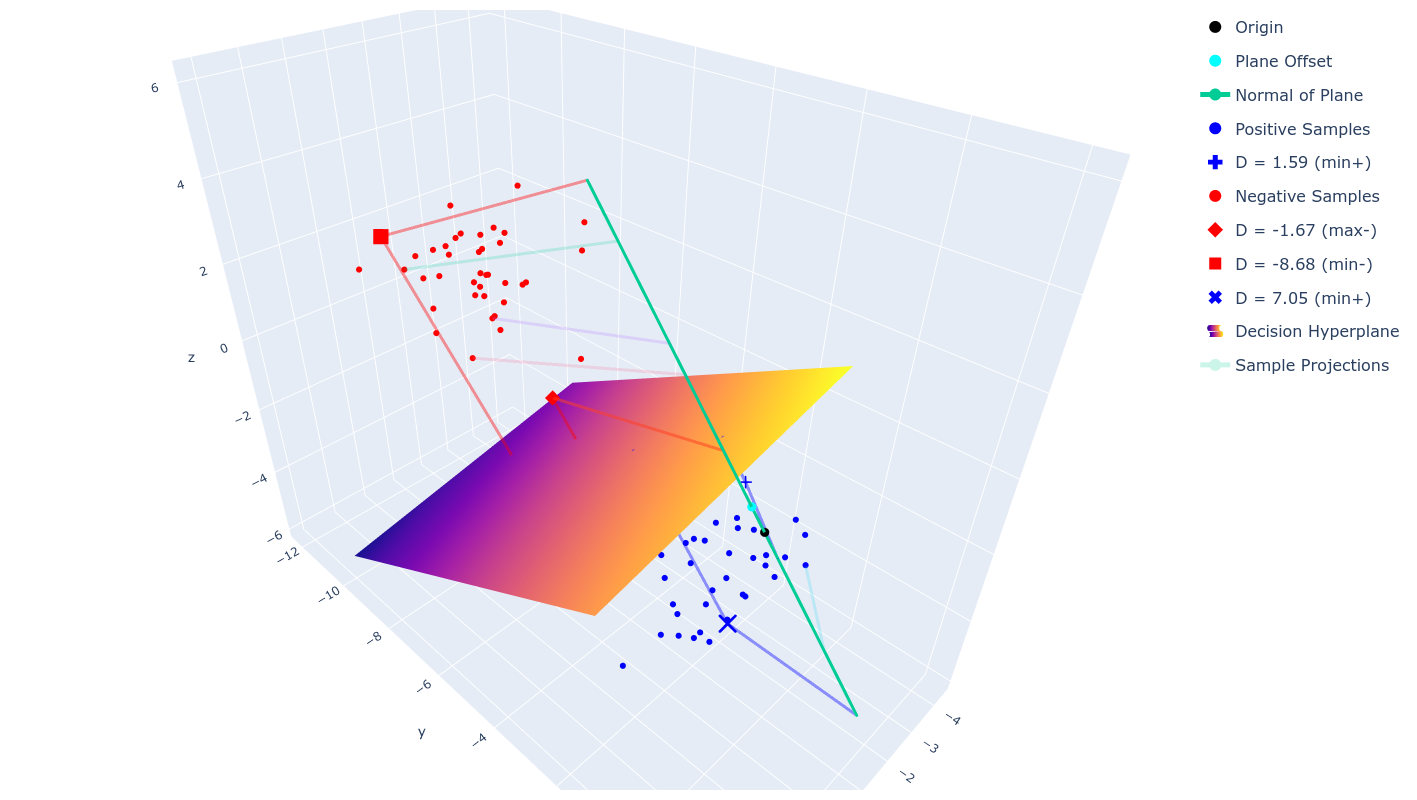

In [ ]:
with ThreeDFigure() as fig: #trafo, back_trafo, swap_axes="xz"
    plane_offset = decision_plane.project([0,0,0]) #point where plane == plane.normal (plane doesn't need to go through [0,0,0])
    fig.add_markers([0,0,0], size=3, name="Origin") #coordinate center
    fig.add_markers(plane_offset, size=3, name="Plane Offset", color="cyan")
    fig.add_line(plane_offset+decision_plane.normal*minneg, plane_offset+decision_plane.normal*maxpos, name="Normal of Plane") 
    
    for point, side in zip(X, y):
        if trafo(point)[0] in [minneg, maxneg, minpos, maxpos]:
            specialnum = ['square', 'diamond', 'cross', 'x'][[minneg, maxneg, minpos, maxpos].index(trafo(point)[0])]
            name = f"D = {trafo(point)[0]:.2f} " + ["(min-)", "(max-)", "(min+)", "(min+)"][[minneg, maxneg, minpos, maxpos].index(trafo(point)[0])]
            fig.add_markers(point, color="blue" if side else "red", size=5, legendgroup=name, marker_symbol=specialnum)
            fig.add_line(point, back_trafo([0, trafo(point)[1], trafo(point)[2]]), color="blue" if side else "red", legendgroup=name, opacity=0.4)            
            fig.add_line(point, ortho_projection_affine(point, decision_plane.normal), color="blue" if side else "red", legendgroup=name, opacity=0.4)
        else:
            fig.add_markers(point, color="blue" if side else "red", legendgroup="Positive Samples" if side else "Negative Samples")


    xx, yy = make_meshgrid(minx=minx, miny=miny, maxx=maxx, maxy=maxy, margin=0.1)
    fig.add_surface(xx, yy, decision_plane.z, name="Decision Hyperplane")
    fig.add_sample_projections(X, decision_plane.normal, n_samples=5, legendgroup="Sample Projections", opacity=0.2)
    fig.fig.update_layout(legend_font_size=16)
    
fig.fig.write_image("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/DecisionplaneDistance.pdf", engine="kaleido")

In [ ]:
fig.fig.write_image("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/DecisionplaneDistance.pdf", engine="kaleido")